In [2]:
import numpy as np
from matplotlib import pyplot as plt
import bgp_qnm_fits as bgp
from scipy.interpolate import CubicSpline
import json
import sxs 
import qnmfits 
import pickle 
from bgp_qnm_fits import (
    get_residuals,
    get_params,
    train_hyper_params,
    kernel_GP,
)

# Constants
ID = '0305'
DATA_TYPE = 'news'
SPHERICAL_MODES = [(2, 2)]
THRESHOLD = 0.9
N_MAX = 6
t0 = 10
T = 100
N_DRAWS = 10000
INCLUDE_CHIF = True
INCLUDE_MF = True
t0_vals = np.arange(0, 40.1, 2)

sim = bgp.SXS_CCE(ID, type=DATA_TYPE, lev="Lev5", radius="R2")
#tuned_param_dict_GP = bgp.get_tuned_param_dict("GP", data_type=DATA_TYPE)[ID]
Mf, chif = sim.Mf, sim.chif_mag

Note that 0305 only has one level, radius, and data type (strain). These arguments will be ignored.


# Get uncertainty estimate

In [3]:
def wfm_to_qnmfit(sim, zero_time=(2,2)):
    data_dict = {} 
    Mf = sim.metadata.remnant_mass
    chif = sim.metadata.remnant_dimensionless_spin
    chif1 = sim.metadata.reference_dimensionless_spin1
    chif2 = sim.metadata.reference_dimensionless_spin2
    h = sim.h
    for l in range(2, 8):
        for m in range(-l, l+1):
            if h.index(l, m) is not None:
                data_dict[(l, m)] = h.data[:, h.index(l, m)]
    times = h.t 

    global_peak_time = qnmfits.Custom(
                            times,
                            data_dict,
                            metadata={
                                "remnant_mass": Mf,
                                "remnant_dimensionless_spin": chif,
                            },
                            zero_time='norm',
                        ).zero_time
    
    return qnmfits.Custom(
            times,
            data_dict,
            metadata={
                "remnant_mass": Mf,
                "remnant_dimensionless_spin": chif,
                "reference_dimensionless_spin1": chif1,
                "reference_dimensionless_spin2": chif2,
                "global_peak_time": global_peak_time,
            },
            zero_time=zero_time,
        )

In [4]:
RESIDUAL_BIG_START = 0
RESIDUAL_BIG_END = 100
TIME_STEP = 0.1

sim_main = wfm_to_qnmfit(sxs.load(f'SXS:BBH:0305/Lev5'), zero_time=(2,2))
sim_lower = wfm_to_qnmfit(sxs.load(f'SXS:BBH:0305/Lev4'), zero_time=(2,2))

# Mask times between -10 and 100
mask_main = (sim_main.times >= -RESIDUAL_BIG_START) & (sim_main.times <= RESIDUAL_BIG_END)
mask_lower = (sim_lower.times >= -RESIDUAL_BIG_START) & (sim_lower.times <= RESIDUAL_BIG_END)

times_masked_main = sim_main.times[mask_main]
times_masked_lower = sim_lower.times[mask_lower]

# Dictionary to hold splines and their derivatives
news_main = {}
news_lower = {}

for mode in sim_main.h:
    h_masked_main = sim_main.h[mode][mask_main]
    h_masked_lower = sim_lower.h[mode][mask_lower]

    spline_real_main = CubicSpline(times_masked_main, h_masked_main.real)
    spline_imag_main = CubicSpline(times_masked_main, h_masked_main.imag)

    spline_real_lower = CubicSpline(times_masked_lower, h_masked_lower.real)
    spline_imag_lower = CubicSpline(times_masked_lower, h_masked_lower.imag)

    news_real_main = spline_real_main.derivative()(times_masked_main)
    news_imag_main = spline_imag_main.derivative()(times_masked_main)
    news_main[mode] = news_real_main + 1j * news_imag_main

    news_real_lower = spline_real_lower.derivative()(times_masked_lower)
    news_imag_lower = spline_imag_lower.derivative()(times_masked_lower)
    news_lower[mode] = news_real_lower + 1j * news_imag_lower

sim_main_news = qnmfits.Custom(
    times_masked_main,
    news_main,
    metadata=sim_main.metadata,
    zero_time=(2, 2),
)

sim_lower_news = qnmfits.Custom(
    times_masked_lower,
    news_lower,
    metadata=sim_lower.metadata,
    zero_time=(2, 2),
)

R_lm_big = get_residuals(
    sim_main_news,
    sim_lower_news,
    RESIDUAL_BIG_START,
    RESIDUAL_BIG_END,
    dt=TIME_STEP,
)

new_times = np.arange(RESIDUAL_BIG_START, RESIDUAL_BIG_START + RESIDUAL_BIG_END, TIME_STEP)

SMOOTHNESS = 1e-3
TIME_SHIFT = 0 

HYPERPARAM_RULE_DICT_WN = {
    "sigma_max": "multiply",
}

params_lm = get_params(
            R_lm_big,
            new_times,
            sim_main.Mf,
            sim_main.chif_mag,
            SMOOTHNESS,
            TIME_SHIFT,
            data_type='news'
        )

Loading SXS simulations using latest tag 'v3.0.0', published at 2025-05-14T18:17:30Z.


/data/vault/rvnd2/python_envs/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/vault/rvnd2/python_envs/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


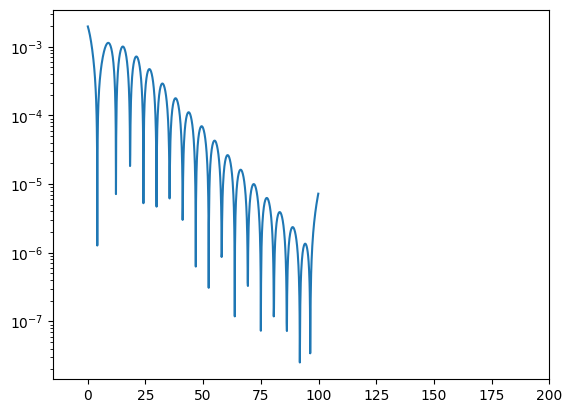

In [5]:
plt.plot(new_times, np.abs(R_lm_big[(2,2)].real))
plt.xlim(-15, 200)
plt.yscale('log')

(-10.0, 200.0)

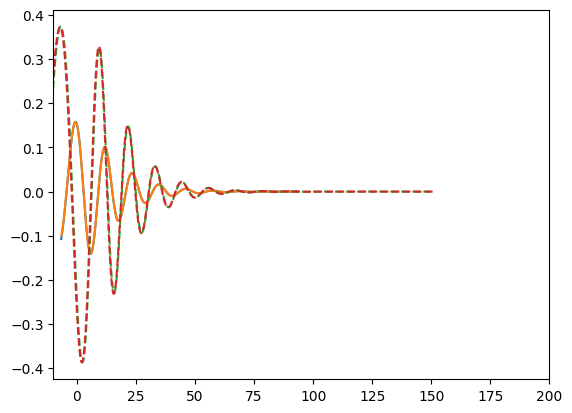

In [6]:
plt.plot(sim_main_news.times, sim_main_news.h[(2,2)].imag)
plt.plot(sim_lower_news.times, sim_lower_news.h[(2,2)].imag)

plt.plot(sim_main.times, sim_main.h[(2,2)].imag, '--')
plt.plot(sim_lower.times, sim_lower.h[(2,2)].imag, '--')

plt.xlim(-10, 200)

In [7]:
tuned_params_WN = bgp.get_tuned_params(params_lm, [1], HYPERPARAM_RULE_DICT_WN)

for key in tuned_params_WN.keys():
    tuned_params_WN[key]["A_min_reg"] = 0

with open(f"tuned_params_WN_SXS.pkl", "wb") as f:
    pickle.dump(tuned_params_WN, f)

# Energy radiated

Simulation 0305: [2 3 4]


/tmp/ipykernel_3547686/2630833928.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


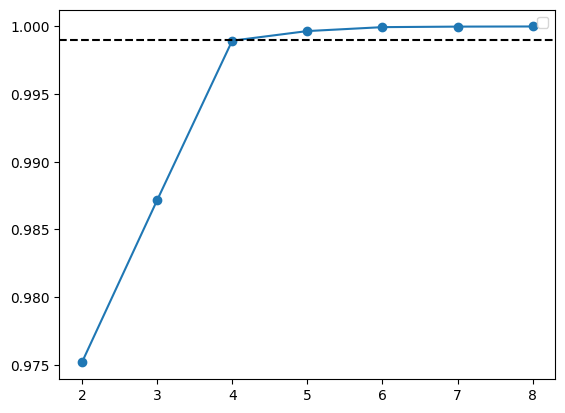

In [8]:
l_vals = np.arange(2, 9)

mask = (sim.times >= -30) & (sim.times <= 100)
energy_total = np.zeros_like(l_vals, dtype = float) 

for i, l in enumerate(l_vals):
    for m in range(-l, l+1):

        hdot = np.diff(sim.h[(l,m)], prepend=0) / np.diff(sim.times, prepend=1) 

        energy_flux = (1/16*np.pi) * np.abs(hdot)**2

        energy_flux_masked = energy_flux[mask]

        energy_total[i] += np.trapz(energy_flux_masked, x=sim.times[mask])

energy_fraction = energy_total / np.sum(energy_total)
energy_cumsum = np.cumsum(energy_fraction)
plt.plot(l_vals, energy_cumsum, marker='o')
below_threshold = l_vals[energy_cumsum <= 0.999]
print(f"Simulation 0305: {below_threshold}")

plt.axhline(0.999, color='k', linestyle='--')
plt.legend() 
plt.show() 

# Get the news and check stuff

In [9]:
# Mask times between -10 and 200
mask = (sim.times >= -10) & (sim.times <= 200)
times_masked = sim.times[mask]

# Dictionary to hold splines and their derivatives
news = {}

for mode in sim.h:
    h_masked = sim.h[mode][mask]
    spline_real = CubicSpline(times_masked, h_masked.real)
    spline_imag = CubicSpline(times_masked, h_masked.imag)
    news_real = spline_real.derivative()(times_masked)
    news_imag = spline_imag.derivative()(times_masked)
    news[mode] = news_real + 1j * news_imag

/data/vault/rvnd2/python_envs/venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/data/vault/rvnd2/python_envs/venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


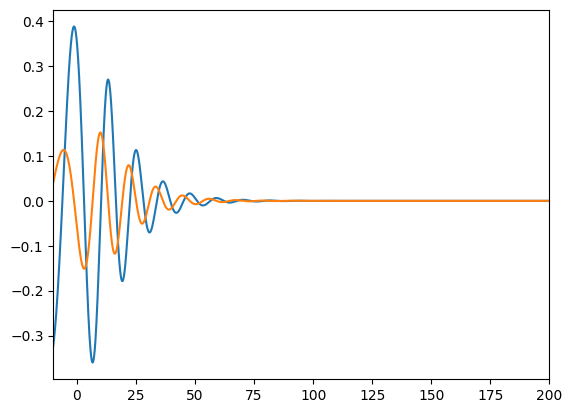

In [10]:
plt.plot(sim.times, sim.h[(2,2)])
plt.xlim(-10, 200)
plt.plot(times_masked, news[(2,2)])

# Determine mode content

In [ ]:
DATA_TYPE = 'news'
L_MAX = 7

SPHERICAL_MODES = [(6, 6), (7, 6)] 

THRESHOLD = 0.9999
N_MAX = 6
T = 100
N_DRAWS = 1000
INCLUDE_CHIF = False
INCLUDE_MF = False

log_threshold = np.log(THRESHOLD)

FILENAME = f'mode_content_files/mode_content_data'

t0_vals = np.arange(0, 60.1, 2)

def get_mode_list(sim_id, initial_modes, candidate_modes, spherical_modes):
    
    sim = bgp.SXS_CCE(sim_id, type=DATA_TYPE, lev="Lev5", radius="R2")
    Mf, chif = sim.Mf, sim.chif_mag

    full_modes_list = [] 
    p_values_median = [] 

    for t0 in t0_vals:
            
        print(f'Fitting from t0={t0}')
        
        select_object = bgp.BGP_select(
            sim.times,
            sim.h,
            initial_modes,
            Mf,
            chif,
            tuned_params_WN,
            bgp.kernel_WN,
            t0=t0,
            candidate_modes=candidate_modes,
            log_threshold=log_threshold,
            candidate_type="prograde_sequential",
            num_draws=N_DRAWS,
            T=T,
            spherical_modes=spherical_modes,
            include_chif=INCLUDE_CHIF,
            include_Mf=INCLUDE_MF,
            data_type=DATA_TYPE
        )

        full_modes_list.append(select_object.full_modes)
        p_values_median.append(np.median(select_object.p_values)) 

    return full_modes_list, p_values_median

candidate_mode_extras = [(3,3,0,1,3,3,0,1), 
                        (2,2,0,1,4,4,0,1),
                        (2,2,0,1,2,2,0,1,2,2,0,1)]  

#candidate_mode_extras = [(2,2,0,1,3,3,0,1)]

spherical_modes = SPHERICAL_MODES

initial_modes = [(*s, 0, 1 if s[1] > 0 else -1) for s in spherical_modes]
candidate_modes = [(*s, n, 1) for s in spherical_modes for n in range(0, N_MAX + 1)] + \
                [(*s, n, -1) for s in spherical_modes for n in range(0, N_MAX + 1)] + \
                candidate_mode_extras + spherical_modes 

print(f"Using initial modes: {initial_modes}")
print(f"Using spherical modes: {spherical_modes}")
print(f"Candidate modes: {candidate_modes}")

mode_selection_data = {
    "sim_id": "0305",
    "times": t0_vals.tolist(),
    "spherical_modes": spherical_modes,
    "threshold": THRESHOLD,
    "initial_modes": initial_modes,
    "candidate_modes": candidate_modes,
    "include_chif": INCLUDE_CHIF,
    "include_Mf": INCLUDE_MF,
}

mode_selection_data[f"modes"], mode_selection_data[f"p_values"] = get_mode_list("0305", initial_modes, candidate_modes, spherical_modes)

with open(f'{FILENAME}_0305.json', 'w') as f:
    json.dump(mode_selection_data, f)

Using initial modes: [(6, 6, 0, 1), (7, 6, 0, 1)]
Using spherical modes: [(6, 6), (7, 6)]
Candidate modes: [(6, 6, 0, 1), (6, 6, 1, 1), (6, 6, 2, 1), (6, 6, 3, 1), (6, 6, 4, 1), (6, 6, 5, 1), (6, 6, 6, 1), (7, 6, 0, 1), (7, 6, 1, 1), (7, 6, 2, 1), (7, 6, 3, 1), (7, 6, 4, 1), (7, 6, 5, 1), (7, 6, 6, 1), (6, 6, 0, -1), (6, 6, 1, -1), (6, 6, 2, -1), (6, 6, 3, -1), (6, 6, 4, -1), (6, 6, 5, -1), (6, 6, 6, -1), (7, 6, 0, -1), (7, 6, 1, -1), (7, 6, 2, -1), (7, 6, 3, -1), (7, 6, 4, -1), (7, 6, 5, -1), (7, 6, 6, -1), (3, 3, 0, 1, 3, 3, 0, 1), (2, 2, 0, 1, 4, 4, 0, 1), (2, 2, 0, 1, 2, 2, 0, 1, 2, 2, 0, 1), (6, 6), (7, 6)]
Note that 0305 only has one level, radius, and data type (strain). These arguments will be ignored.
Fitting from t0=0.0


Stopping: no more significant modes
Next mode is (2, 2, 0, 1, 2, 2, 0, 1, 2, 2, 0, 1) with log significance -0.0003323146034160849
Final mode content [(6, 6, 0, 1), (7, 6, 0, 1)]
Fitting from t0=1.0
Adding mode (2, 2, 0, 1, 2, 2, 0, 1, 2, 2, 0, 1) with significance 0.9999919495655792.
Adding mode (3, 3, 0, 1, 3, 3, 0, 1) with significance 0.9999999910656588.
Stopping: no more significant modes
Next mode is (2, 2, 0, 1, 4, 4, 0, 1) with log significance -0.022093697512659743
Final mode content [(6, 6, 0, 1), (7, 6, 0, 1), (2, 2, 0, 1, 2, 2, 0, 1, 2, 2, 0, 1), (3, 3, 0, 1, 3, 3, 0, 1)]
Fitting from t0=2.0
Adding mode (2, 2, 0, 1, 2, 2, 0, 1, 2, 2, 0, 1) with significance 0.9999996917107329.
Adding mode (3, 3, 0, 1, 3, 3, 0, 1) with significance 0.9999999889002087.
Stopping: no more significant modes
Next mode is (2, 2, 0, 1, 4, 4, 0, 1) with log significance -0.005968851933273143
Final mode content [(6, 6, 0, 1), (7, 6, 0, 1), (2, 2, 0, 1, 2, 2, 0, 1, 2, 2, 0, 1), (3, 3, 0, 1, 3, 3, 0, 1